# Maven Power Outage Challenge - Exploratory Data Analysis

[insert description of challenge, data and objectives]

## Step 0. Understanding the data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import openpyxl

In [5]:
# Define the sheet names in a list so that we can easily iterate through the excel sheets (tabs). 
# Each sheet contains power outage event data for a year between 2002 and 2023

sheet_names = [str(n) for n in range(2002, 2024, 1)]

In [6]:
# Creating a dictionary of pandas dataframes, one dataframe per excel sheet. 
# this will allow us to tailor our data cleaning to the individual sheet since the format of the sheet changes over the years.

DF_dict = {}

for sheet in sheet_names:
    if sheet in ["2002", "2008"]:
        header_value = 2
    else:
        header_value = 1
    
    DF_dict["{0}".format(sheet)] = pd.read_excel('DOE_Electric_Disturbance_Events.xlsx', 
                                                 engine='openpyxl', 
                                                 header=header_value, 
                                                 sheet_name=sheet)

In [7]:
# We will not use this right now, but the dictionary starting_shapes will help us to 
# understand the data better as we are cleaning

starting_shapes = {}
for sheet in sheet_names:
    starting_shapes[sheet] = DF_dict[str(sheet)].shape


In [8]:
# Now lets check out one of the dataframes to see if we get the data we expect:
DF_dict["2008"].head()

,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Date/Time,NaN,NaN,NaN,NaN
1,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-04 00:00:00,WECC,4:00 a.m.,Northern California,Winter Storm,500,2606931,5:00 p.m. January 14,NaN,NaN,NaN,NaN
3,2008-01-04 00:00:00,WECC,7:47 a.m.,Sacramento County,Severe Storm,300,150000,4:30 p.m. January 04,NaN,NaN,NaN,NaN
4,2008-01-29 00:00:00,WECC,5:00 a.m.,"San Francisco Bay Area, California",Exciter Faulted,NaN,-,12:17 p.m. January 29,NaN,NaN,NaN,NaN


The data above is what I expect, however it is very messy! Generally I will need to:
- Make sure columns in each dataframe match (i.e. contain the same feature information)
- Check data within the columns to ensure quality
- Concatenate thesource dataframes to create a single datasource

In [9]:
# Now lets explore how the column names vary between dataframes:

column_title_dictionary = {"{0}".format(sheet):DF_dict["{0}".format(sheet)].columns.tolist() for sheet in sheet_names}
column_title_df = pd.DataFrame.from_dict(column_title_dictionary, orient='index') #use the orient argument to make the keys of the dictionary equivalent to the index values of the dataframe
column_title_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2002,Date,NERC Region,Time,Area,Type of Disturbance,Loss (megawatts),Number of Customers Affected,Restoration Time,None,None,None,None,None,None,None,None,None,None,None
2003,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2004,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2005,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2006,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2007,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1[1],Restoration,None,None,None,None,None,None,None,None,None,None,None
2008,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,None,None,None,None,None,None,None
2009,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2010,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2011,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18


### The target column names

From the dataframe above, we can see that the columns titles make a significant change two times between 2002 - 2023. 

I will approach the data cleaning process slightly differently for each of the three periods: 2002-2010, 2011-2014, 2015-2023

Here are the column names that I will have in the cleaned and concatenated dataframe:
1. "datetime_event_began", 
2. "NERC_region", 
3. "area_affected", 
4. "event_type", 
5. "demand_loss_(MW)", 
6. "number_of_customers_affected", 
7. "datetime_of_restoration"

In [10]:
post_cleaning_column_titles = ["datetime_event_began", 
                               "NERC_region", 
                               "area_affected", 
                               "event_type", 
                               "demand_loss_(MW)", 
                               "number_of_customers_affected", 
                               "datetime_of_restoration"]

## Step 1. Cleaning the data

### How will I manipulate the dataframes so that I have seven consistent features accross all dataframes?
From 2002 to 2010:
- reorder columns so that columns 1 and 2 switch places(i.e. "Time" comes before NERC Region)
- concatenate columns 0 and 1. This value will override existing column 0 and should leave you with one column that containes datetime_event_begins
- rename columns so that they match the names from post_cleaning_column_titles

From 2011 to 2014:
- 

From 2015 to 2023:

### Cleaning dataframes from the years 2002 - 2010:

In [11]:
# for the dataframes containing data from 2002 to 2010, I am starting by reordering columns so that columns 1 and 2 switch places(i.e. "Time" comes before NERC Region)
for sheet in list(range(2002,2011,1)):
    temp_cols_list = DF_dict["{0}".format(sheet)].columns.tolist()
    save_col1 = temp_cols_list[1] 
    temp_cols_list[1] = temp_cols_list[2]
    temp_cols_list[2] = save_col1
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][temp_cols_list]

In [12]:
# Lets create a function that takes a dataframe, iterates through the rows, and checkes that the "Date" column to a 
# datetime datatype. otherwise it drops the row because this indicates the row is an unexpected format and in this instance 
# most likely a human readable marker.

from datetime import datetime

def drop_non_datetime_values(dataframe_name, column_name):
    for ind, row in dataframe_name.iterrows():
        if type(dataframe_name[column_name][ind]) == datetime:
            pass
        else:
            dataframe_name.drop(axis=0, index=ind, inplace=True)
    return dataframe_name
           

In [13]:
# Removing rows from the dataframe that are redundant or that repeat the column names.
for sheet in list(range(2002,2011,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date")

In [14]:
# We have discovered some "Time" value that can not be changed to a time datatype due to how 
# they have been entered into the database. I will adjust these one-by-one to preserve as much information as possible:

DF_dict["2002"].loc[3, "Time"] = "20:00:00"  # Original value = "Evening"
DF_dict["2003"].loc[56, "Time"] = "15:00:00" # Original value = "Approximately 3:00 p.m."
DF_dict["2003"].loc[78, "Time"] = "12:00:00" # Original value = "12:00 noon"
DF_dict["2004"].loc[3, "Time"] = "00:00:00"  # Original value = "Midnight"
DF_dict["2004"].loc[81, "Time"] = "09:52:00" # Original value = "9: 52 a.m."
DF_dict["2005"].loc[13, "Time"] = "17:28:00" # Original value = "5:78 p.m."
DF_dict["2005"].loc[21, "Time"] = "00:00:00" # Original value = "Midnight"
DF_dict["2006"].loc[12, "Time"] = "00:00:00" # Original value = "Ongoing"

# This is the code I used to find the index value of the problematic time data:
# DataFrame_dict["sheet2006"][DataFrame_dict["sheet2006"]["Time"] == "Ongoing"].index.values[0]

In [15]:
# Now that the date and time columns are in a format that can be recognised by pd.to_datetime, 
# lets concatenate these two columns

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)]['Date'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]['Time'].astype(str))

In [16]:
# Now that the time data is included in the first column of our dataframe we can drop the "Time" column 
# from the dataframes containing data for years 2002 - 2010

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop("Time", axis=1)

In [17]:
DF_dict["2002"].head()

,Date,NERC Region,Area,Type of Disturbance,Loss (megawatts),Number of Customers Affected,Restoration Time
1,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
3,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
4,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
6,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
8,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


In [18]:
# Now that dataframes for 2002 - 2010 are fairly clean let us standardise the column names so we can concatenate the dataframes:

for sheet in list(range(2002,2011,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)


In [19]:
DF_dict["2002"].head() #Note, there is still some cleaning to do but we have the dataframe in the general format we want

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
1,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
3,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
4,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
6,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
8,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


In [20]:
# Now we will move on to the dataframes that contain data for years 2011 - 2014. Lets look at the dataframe:
DF_dict["2012"].head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,January,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-04 00:00:00,12:14:00,2012-01-04 00:00:00,12:14:00,"Tacoma, Washington",WECC,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
2,2012-01-05 00:00:00,10:35:00,2012-01-05 00:00:00,12:25:00,"CSWS/AEP West territory, Oklahoma",SPP,Sabotage,0,0,NaN,NaN,NaN
3,2012-01-05 00:00:00,10:28:00,2012-01-05 00:00:00,12:25:00,"Creek County, Oklahoma",SPP,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
4,2012-01-09 00:00:00,14:30:00,2012-01-09 00:00:00,15:30:00,"Watertown, Connecticut",NPCC,Vandalism,NaN,NaN,NaN,NaN,NaN


In [21]:
# Step one, drop values from "Date Event Began" that are not datetime datatypes:
for sheet in list(range(2011,2015,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date Event Began")

In [22]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

def date_only(start_year, stop_year, name_of_date_col):
    for sheet in list(range(start_year, stop_year+1, 1)):
        DF_dict["{0}".format(sheet)][name_of_date_col] = pd.to_datetime(DF_dict["{0}".format(sheet)][name_of_date_col]).dt.date
        

In [23]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

date_only(2011,2014,'Date Event Began')

In [24]:
DF_dict["2012"].head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11
1,2012-01-04,12:14:00,2012-01-04 00:00:00,12:14:00,"Tacoma, Washington",WECC,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
2,2012-01-05,10:35:00,2012-01-05 00:00:00,12:25:00,"CSWS/AEP West territory, Oklahoma",SPP,Sabotage,0,0,NaN,NaN,NaN
3,2012-01-05,10:28:00,2012-01-05 00:00:00,12:25:00,"Creek County, Oklahoma",SPP,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
4,2012-01-09,14:30:00,2012-01-09 00:00:00,15:30:00,"Watertown, Connecticut",NPCC,Vandalism,NaN,NaN,NaN,NaN,NaN
5,2012-01-09,13:36:00,2012-01-11 00:00:00,01:05:00,Louisiana,SERC,Load Shed,150,1,NaN,NaN,NaN


In [25]:
# Merge date and time information

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [26]:
#Let us make sure the third column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

for sheet in list(range(2011,2015,1)):
    for ind, row in DF_dict["{0}".format(sheet)].iterrows():
        if type(DF_dict["{0}".format(sheet)]['Date of Restoration'][ind]) != datetime:
            DF_dict["{0}".format(sheet)]['Date of Restoration'][ind] = datetime.now().date()
            #DataFrame_dict["sheet{0}".format(sheet)]['Time of Restoration'][ind] = datetime.now().time()
            
        if type(DF_dict["{0}".format(sheet)]['Time of Restoration'][ind]) == str:
            DF_dict["{0}".format(sheet)]['Time of Restoration'][ind] = "00:00:00"
    
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration']).dt.date
        

c:\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\python36-32\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [27]:
for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [28]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [29]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [30]:
for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [31]:
DF_dict["2014"].head()

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
1,2014-01-06 19:50:00,RFC,District of Columbia,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:44:00
2,2014-01-06 19:50:00,RFC,Unknown,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:44:00
3,2014-01-06 19:52:00,RFC,Delaware,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:45:00
4,2014-01-06 20:45:00,RFC,Unknown,Public Appeal due to Severe Weather - Cold,Unknown,Unknown,2014-01-07 21:00:00
5,2014-01-06 19:50:00,RFC,Pennsylvania,Voltage Reduction due to Severe Weather - Cold,200,62000,2014-01-06 20:49:00


In [32]:
# Now we will move on to the dataframes that contain data for years 2015 - 2023. Lets look at the dataframe:

In [33]:
DF_dict["2018"].head()

,Month,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected
0,January,01/01/2018,18:21:00,01/02/2018,18:11:00,Tennessee:,SERC,Public appeal to reduce the use of electricity...,Severe Weather,Unknown,Unknown
1,January,01/01/2018,17:43:00,Unknown,Unknown,Texas:,TRE,Public appeal to reduce the use of electricity...,Severe Weather,Unknown,Unknown
2,January,01/01/2018,21:37:00,01/02/2018,10:30:00,Tennessee:,SERC,Public appeal to reduce the use of electricity...,System Operations,Unknown,Unknown
3,January,01/02/2018,10:00:00,02/12/2018,08:00:00,New York: Niagara County;,NPCC,Fuel supply emergencies that could impact elec...,Fuel Supply Deficiency,675,Unknown
4,January,01/02/2018,07:30:00,Unknown,Unknown,South Carolina:,SERC,Public appeal to reduce the use of electricity...,Severe Weather,0,717000


In [34]:
# Drop month column because it is redundant and also drop alert criteria column, we will not be analysing this column this time. 

for sheet in list(range(2015,2024,1)):
    column_titles = DF_dict["{0}".format(sheet)].columns.tolist()
    if "Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Month"], axis=1)
    if "Event Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Month"], axis=1)
    if "Event Year" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Year"], axis=1)
    if "Alert Criteria" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Alert Criteria"], axis=1)

In [35]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

date_only(2015, 2023, "Date Event Began")

In [36]:
# We have data issues in sheets 2015, 2016, 2017. 
# The issue is that these sheets have many rows of NaNs at the very bottom of the spreadsheet that we need to remove

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

2015 48
2016 50
2017 41
2018 0
2019 0
2020 0
2021 0
2022 0
2023 0


In [37]:
# instead of dropping rows that have NaN, how about we keep rows that are not NaN:

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date Event Began'].notna()]

In [38]:
# The code above has resolved the issues of the NaNs at the very bottom of some of the spreadsheets

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

2015 0
2016 0
2017 0
2018 0
2019 0
2020 0
2021 0
2022 0
2023 0


In [39]:
# keep rows that are not "Unknown" 
# (There are a significant number of unknown values that are preventing us from processing the datetime columns properly)

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date of Restoration'].str.strip(" ") !=  "Unknown"]

In [40]:
# Merge Date Event Began and Time Event Began 

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [41]:
# Now we want to combine the restoration date and restoration time columns. 
# But first we need to get rid of two problematic rows that are missing critical data

DF_dict["2022"].drop(66, axis=0, inplace=True)
DF_dict["2023"].drop(13, axis=0, inplace=True)

In [42]:
for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [43]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [44]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [45]:
for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [46]:
DF_dict["2016"]

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2016-01-04 05:15:00,MRO,Wisconsin: Milwaukee County;,Sabotage,0,0,2016-01-05 08:00:00
1,2016-01-10 20:46:00,NPCC,Maine: Connecticut: Massachusetts: Vermont: Ne...,Weather,Unknown,59859,2016-01-11 05:25:00
2,2016-01-11 20:16:00,RFC,Pennsylvania: Chester County;,Vandalism,0,0,2016-01-11 23:00:00
3,2016-01-14 08:27:00,RFC,Delaware:,Vandalism,0,0,2016-01-14 12:00:00
4,2016-01-17 12:00:00,WECC,Utah: Salt Lake County;,Sabotage,0,0,2016-01-17 13:00:00
...,...,...,...,...,...,...,...
136,2016-12-16 07:45:00,WECC,Oregon: Multnomah County;,Vandalism,0,0,2016-12-16 08:45:00
137,2016-12-26 04:00:00,WECC,Washington:,Vandalism,0,0,2016-12-26 06:00:00
138,2016-12-28 04:03:00,WECC,California:,Fuel Supply Deficiency,0,0,2016-12-31 06:00:00
139,2016-12-30 08:55:00,NPCC,Vermont: Chittenden County;,Other,0,0,2016-12-30 08:56:00


In [47]:
# Now that dataframes for 2002 - 2023 are fairly clean and standardised, lets concatenate them:

disturbances = DF_dict["2002"]

for sheet in list(range(2003,2024,1)):
    disturbances = disturbances.append(DF_dict["{0}".format(sheet)], ignore_index=True)

disturbances

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
1,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
2,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
3,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
4,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00
...,...,...,...,...,...,...,...
3613,2023-06-25 19:30:00,SERC,"Arkansas, Mississippi",- Weather or natural disaster,Unknown,64732,2023-06-26 17:45:00
3614,2023-06-27 17:37:00,WECC,"Washington, Idaho, Montana",- Failure at high voltage substation or switch...,0,0,2023-06-27 21:30:00
3615,2023-06-28 11:01:00,SERC,Georgia,- Vandalism - Theft,0,0,2023-06-28 11:03:00
3616,2023-06-22 02:30:00,SERC,Louisiana,- Transmission equipment failure,17,6242,2023-06-22 02:38:00


## Step 2. Feature engineering

In [48]:
disturbances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   datetime_event_began          3618 non-null   object
 1   NERC_region                   3598 non-null   object
 2   area_affected                 3618 non-null   object
 3   event_type                    3618 non-null   object
 4   demand_loss_(MW)              3230 non-null   object
 5   number_of_customers_affected  3410 non-null   object
 6   datetime_of_restoration       3617 non-null   object
dtypes: object(7)
memory usage: 99.0+ KB


In [49]:
## CREATE A duplicate dataframe to revert back to in case I do something silly to the disturbancesDF:

disturbances_copy = disturbances.copy()

In [205]:
#Use this code to revert back to the starting DF
#disturbances = disturbances_copy

In [50]:
# 
disturbances["datetime_of_restoration"].iloc[14] = "2002-11-10 12:00:00"
disturbances["datetime_of_restoration"].iloc[15] = None

In [51]:
## Convert the columns "Datetime_event_began" and "Datetime_of_restoration" to a datetime datatype:

disturbances["datetime_event_began"] = pd.to_datetime(disturbances["datetime_event_began"], format= "%Y-%m-%d %H:%M:%S", utc=True)
#disturbances["datetime_of_restoration"] = pd.to_datetime(disturbances["datetime_of_restoration"], format= "%Y-%m-%d %H:%M:%S", utc=True)

## Step 3. Exploratory Data Analysis (EDA)

In [52]:
# The column "number_of_customers_affected" is currently a string, lets try converting this to an int.

for ind, row in disturbances.iterrows():
    try:
        disturbances["number_of_customers_affected"][ind] = int(disturbances["number_of_customers_affected"][ind])
    except:
        disturbances["number_of_customers_affected"][ind] = None

c:\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [54]:
# Now lets convert the column "number of customers affected" to an int

disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].fillna(0).astype(int)
disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].astype(str).astype(int)

In [55]:
disturbances.head()

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2002-01-30 06:00:00+00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
1,2002-01-29 20:00:00+00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
2,2002-01-30 16:00:00+00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
3,2002-02-27 10:48:00+00:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
4,2002-03-09 00:00:00+00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


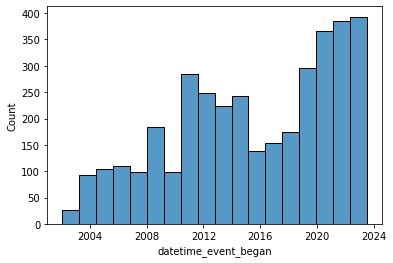

In [132]:
sns.histplot(data=disturbances, x='datetime_event_began')
plt.show()

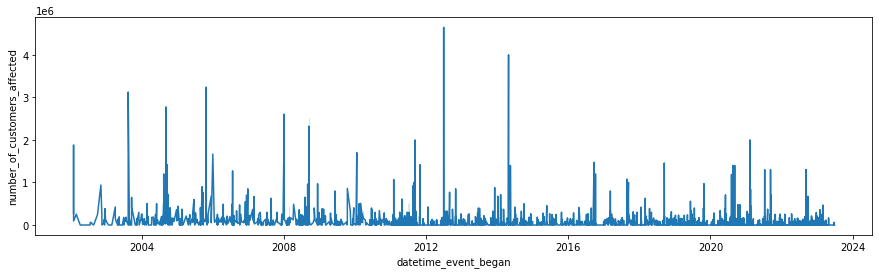

In [269]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=disturbances, x='datetime_event_began', y="number_of_customers_affected")
plt.show()

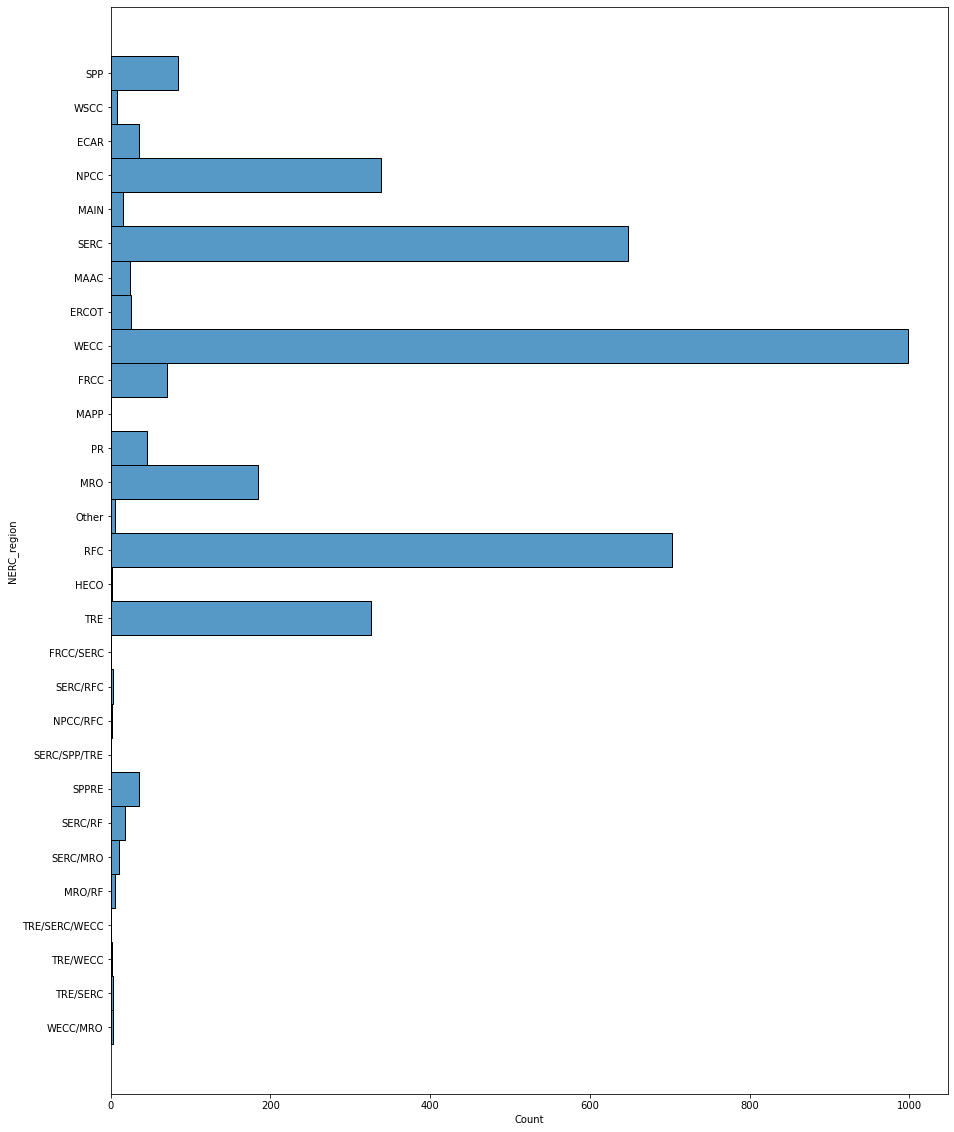

In [70]:
plt.figure(figsize=(15, 20))
sns.histplot(data=disturbances, y='NERC_region')
plt.show()

In [66]:
# There seems to be a lot of NERC_regions, lets get the count:

NERC_region_count = disturbances["NERC_region"].value_counts()
NERC_region_count

WECC              998
SERC              648
RFC               481
NPCC              336
TRE               326
RF                222
MRO               183
SPP                84
FRCC               70
PR                 45
SPPRE              35
ECAR               35
ERCOT              26
MAAC               24
MAIN               15
SERC/RF            10
RF/SERC             8
WSCC                8
MRO/SERC            5
SERC/MRO            5
MRO/RF              5
WECC/MRO            3
TRE/SERC            3
HECO                2
TRE/WECC            2
RFC;SERC            2
MidwestISO(RFC      1
MAPP                1
NPPC                1
RF/MRO              1
HI                  1
MR0                 1
NPCC,RFC            1
NPCC;RFC            1
TE                  1
TRE/SERC/WECC       1
RFC,SERC            1
SPP,SERC,TRE        1
WeEnergiesMAIN      1
NP                  1
FRCC/SERC           1
MECO                1
REC                 1
Name: NERC_region, dtype: int64

In [69]:
# There seem to be some NERC codes that have spaces, lets clean these up by removing the spaces:
disturbances["NERC_region"] = disturbances["NERC_region"].str.replace(" ", "")

# We also want to address some naming inconsistencies in the data:
disturbances["NERC_region"] = disturbances["NERC_region"].replace(
    {
        "RF":"RFC",
        "RF/SERC":"SERC/RF",
        "MRO/SERC":"SERC/MRO",
        "RFC;SERC":"SERC/RFC",
        "NPPC":"NPCC",
        "RF/MRO":"MRO/RF",
        "MR0":"MRO",
        "NPCC,RFC":"NPCC/RFC",
        "NPCC;RFC":"NPCC/RFC",
        "RFC,SERC":"SERC/RFC",
        "SPP,SERC,TRE":"SERC/SPP/TRE",
        "NP":"NPCC",
        "MECO":"Other",
        "REC":"Other",
        "HI":"Other",
        "MidwestISO(RFC":"Other",
        "TE":"Other",
        "WeEnergiesMAIN":"Other"
    })

In [71]:
# Create a dictionary that defines the NERC Region code:
NERC_region_dict = {
    "MRO": "Midwest Reliability Organisation",
    "NPCC": "Northeast Power Coordinating Council",
    "RFC": "ReliabilityFirst Corporation",
    "SERC": "SERC Reliability Corporation",
    "SPP": "Southwest Power Pool",
    "TRE": "Texas Reliability Entity",
    "WECC": "Western Electricity Coordinating Council",
    "FRCC": "Florida Reliability Coordinating Council",
    "MAPP": "Mid-continent Area Power Pool",
    "HECO": "Hawaiian Electric",
    "MAAC": "Mid-Atlantic Area Council",
    "WSCC": "Western Systems Coordinating Council",
    "MAIN": "Mid-America Interconnected Network",
    "ERCOT": "Electric Reliability Council of Texas",
    "ECAR": " East Central Area Reliability Coordination Agreement",
    "SPP RE": "SPP Regional Entity",  
}




## Step 4 Conclusion and next steps

In [ ]:
# NOTE: I have lost some of the merged cell data from the area column of 2002 sheet, to revisit and look at data dictionary for better understanding
# NOTE: Have i deleted some important data when cleaning my rows that are not datetime data? to review.
# NOTE: when converting the datetime columns to datetime datatypes I set utc=True. This will need to be reviewed.
# NOTE: This is where I found the NERC region code translations: https://www.eia.gov/outlooks/aeo/pdf/nerc_map.pdf